In [1]:
%load_ext watermark
import pandas as pd
import session_config
import userdisplay

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Point

from matplotlib.lines import Line2D
from shapely.ops import unary_union


from myst_nb import glue

In [2]:
def a_point_buffer(this_location: pd.Series, buffer_radius: int = 1500, coordinate_crs: str = 'epsg:4326', to_crs: str = "epsg:2056"):
    # create a point, a buffer and buffer bounds for one location
    this_geometry = [Point(this_location.longitude, this_location.latitude)]
    this_shape = gpd.GeoDataFrame(this_location, geometry=this_geometry, crs=coordinate_crs)
    this_shape = this_shape.to_crs(to_crs)

    this_buffer = gpd.GeoDataFrame(geometry=this_shape.buffer(1500), crs=to_crs)
    location_buffer = this_buffer.dissolve()
    return this_shape, location_buffer, location_buffer.total_bounds


def location_geo_attributes(bounds, buffer, shape_file, objcolumn: str = 'OBJVAL', objval: str ='land-cover', buffer_name: str = None):
    minx, miny, maxx, maxy = bounds
    landcover = gpd.read_file(shape_file, bbox=(minx, miny, maxx, maxy))
    landcover = landcover.drop_duplicates()
    landcover = gpd.overlay(landcover, buffer, how='intersection', keep_geom_type=True)
    landcover.rename(columns={objcolumn:objval}, inplace=True)
    
    landcover['buffer-name'] = buffer_name
    return landcover[['buffer-name', objval, 'geometry']], landcover['land-cover'].unique()

def assign_colors_to_polygons(buffer_contents: gpd.GeoDataFrame, colors: dict = None, objval: str = None):
    buffer_contents['color'] = buffer_contents[objval].map(colors)
    return buffer_contents
    
def compute_landuse_percent_of_buffer(buffer_contents, buffer_area):

    land_covers = buffer_contents['land-cover'].unique()

    if 'Stausee' in land_covers:
        
        if 'See' in land_covers:
            see_stausee_gdf = buffer_contents[buffer_contents['land-cover'].isin(['See', 'Stausee'])]
            combined_geometry = unary_union(see_stausee_gdf['geometry'])
            new_row = {
                'buffer-name': buffer_contents['buffer-name'].unique()[0],
                'land-cover': 'See',
                'geometry': combined_geometry
            }
            buffer_contents = buffer_contents[~buffer_contents['land-cover'].isin(['See', 'Stausee'])]
            
            new_gdf = gpd.GeoDataFrame([new_row], columns=buffer_contents.columns, crs=buffer_contents.crs)

            # Concatenate the original GeoDataFrame with the new GeoDataFrame
            buffer_contents = pd.concat([buffer_contents, new_gdf], ignore_index=True)
            
        else:
            see_stausee_gdf = buffer_contents[buffer_contents['land-cover'].isin(['Stausee'])]
            a_geometry = unary_union(see_stausee_gdf['geometry'])
            new_row = {
                'buffer-name': buffer_contents['buffer-name'].unique()[0],
                'land-cover': 'See',
                'geometry': a_geometry
            }
            buffer_contents = buffer_contents[~buffer_contents['land-cover'].isin(['See', 'Stausee'])]
            
            new_gdf = gpd.GeoDataFrame([new_row], columns=buffer_contents.columns, crs=buffer_contents.crs)

            # Concatenate the original GeoDataFrame with the new GeoDataFrame
            buffer_contents = pd.concat([buffer_contents, new_gdf], ignore_index=True)
            

    if 'See' in buffer_contents['land-cover'].unique():
        water_surface = buffer_contents.loc[buffer_contents['land-cover'] == 'See', 'geometry'].geometry.area.values[0]
        buffer_contents['buffer-area-dry'] = buffer_area - water_surface
        buffer_contents['area_m2'] = buffer_contents.geometry.area
        buffer_contents['buffer-area-dry'] = buffer_area - water_surface
        buffer_contents['rate'] = buffer_contents.area_m2/buffer_contents['buffer-area-dry']

    else:
        buffer_contents['area_m2'] = buffer_contents.geometry.area
        buffer_contents['buffer-area-dry'] = buffer_area
        buffer_contents['rate'] = buffer_contents.area_m2/buffer_contents['buffer-area-dry']    
    return buffer_contents


# # Assuming your GeoDataFrame is named gdf
# # Filter out 'See' and 'Stausee' rows
# see_stausee_gdf = gdf[gdf['land-cover'].isin(['See', 'Stausee'])]

# # Combine the geometries
# combined_geometry = unary_union(see_stausee_gdf['geometry'])

# # Create a new row with the combined geometry


# # Drop the original 'See' and 'Stausee' rows
# gdf = gdf[~gdf['land-cover'].isin(['See', 'Stausee'])]

# # Append the new combined row
# gdf = gdf.append(new_row, ignore_index=True)

# # Calculate the area of the new combined geometry
# gdf['area'] = gdf['geometry'].area


def compute_undefined_sections_of_buffer(buffer, buffer_contents, objval: str = 'land-cover', buffer_name: str = 'None'):
    undefined = buffer.geometry.iloc[0]
    
    for aval in buffer_contents.geometry:
        undefined = undefined.difference(aval)
    args = {
        'geometry':[undefined],
        objval : ['undefined'],
        'buffer-name':[ buffer_name]
    }
    undef = gpd.GeoDataFrame(args, crs=buffer.crs)

    return undef

In [3]:
gpd.options.io_engine = "pyogrio"

data = session_config.collect_survey_data()
beaches = pd.read_csv('data/end_process/beaches.csv').set_index('slug')
locations = beaches.index

river_beaches = beaches[beaches.feature_type == 'r'].copy()

river_locations = river_beaches.index

lake_beaches = beaches[beaches.feature_type == 'l'].copy()
lake_locations = lake_beaches.index

locations_and_coordinates = beaches.loc[locations, ['latitude', 'longitude', 'feature_type']]
coordinate_crs = 'epsg:4326'
to_crs = 'epsg:3857'
not_done = [x for x in beaches.index if x not in locations_and_coordinates.index]


land_use_colors = {
    'Wald': 'olivedrab',
    'Fels': 'gray',
    'Geroell': 'gray',
    'Gletscher': 'gray',
    'Stausee': 'blue',
    'See': 'blue',
    'Reben': 'seagreen',
    'Obstanlage': 'yellowgreen',
    'Siedl': 'slategray',
    'Sumpf': 'yellow',
    'undefined': 'khaki'
}

In [4]:


land_uses_l = []
for a_location in lake_locations:
    this_location = locations_and_coordinates.loc[[a_location]].copy()
    this_point, abuffer, bufferbounds = a_point_buffer(this_location)
    buffer_content_i, names = location_geo_attributes(bufferbounds, abuffer, 'data/ignorethis/shapes/landcover.shp', buffer_name=a_location)
    
    # identify the undefined areas
    combined_polygon = unary_union(buffer_content_i.geometry)
    combined_Pn = gpd.GeoDataFrame({'geometry': [combined_polygon]}, crs=buffer_content_i.crs)
    undefined = compute_undefined_sections_of_buffer(abuffer,combined_Pn, buffer_name=a_location)
    
    # combine the known land cover with the undefined
    buffer_content_i = pd.concat([buffer_content_i, undefined])
    
    args = dict(objcolumn='OBJEKTART', objval='land-cover', buffer_name=a_location)
    nz, _ = location_geo_attributes(bufferbounds, abuffer, 'data/ignorethis/shapes/nutuzungsareal.shp', **args)
    nz_comb = unary_union(nz.geometry)
    nz_comb = gpd.GeoDataFrame([{'geometry': nz_comb, 'buffer-name':a_location, 'land-cover': 'public-services' }], crs=buffer_content_i.crs)
    
    
    fz,_ = location_geo_attributes(bufferbounds, abuffer,'data/ignorethis/shapes/freizeit.shp', **args)
    fz_comb = unary_union(fz.geometry)
    fz_comb = gpd.GeoDataFrame([{'geometry': fz_comb, 'buffer-name':a_location, 'land-cover': 'recreation' }], crs=buffer_content_i.crs)
    q = pd.concat([buffer_content_i, nz_comb, fz_comb])
    
    
    # indentify the contents of the buffer
    minx, miny, maxx, maxy = bufferbounds
    streets = gpd.read_file('data/ignorethis/shapes/strasse.shp',bbox=(minx, miny, maxx, maxy))
    streets = streets.drop_duplicates()
    streets = streets.dissolve()
    streets = gpd.overlay(streets, abuffer, how='intersection', keep_geom_type=True)
    
    t = compute_landuse_percent_of_buffer(q, abuffer.geometry.area[0])
    t = t.groupby('land-cover').rate.sum()
    t['streets'] = streets.geometry.length[0]
    t.drop('See', inplace=True)
    t['location'] = a_location
    land_uses_l.append(t)

In [5]:
f = pd.DataFrame(land_uses_l).round(3)
f.fillna(0, inplace=True)
f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, rate to rate
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Siedl            128 non-null    float64
 1   Sumpf            128 non-null    float64
 2   Wald             128 non-null    float64
 3   public-services  128 non-null    float64
 4   recreation       128 non-null    float64
 5   undefined        128 non-null    float64
 6   streets          128 non-null    float64
 7   location         128 non-null    object 
 8   Reben            128 non-null    float64
 9   Fels             128 non-null    float64
 10  Stadtzentr       128 non-null    float64
 11  Obstanlage       128 non-null    float64
 12  Geroell          128 non-null    float64
dtypes: float64(12), object(1)
memory usage: 14.0+ KB


In [6]:
land_uses_r = []
for a_location in river_locations:
    this_location = locations_and_coordinates.loc[[a_location]].copy()
    this_point, abuffer, bufferbounds = a_point_buffer(this_location)
    buffer_content_i, names = location_geo_attributes(bufferbounds, abuffer, 'data/ignorethis/shapes/landcover.shp', buffer_name=a_location)
    
    # identify the undefined areas
    combined_polygon = unary_union(buffer_content_i.geometry)
    combined_Pn = gpd.GeoDataFrame({'geometry': [combined_polygon]}, crs=buffer_content_i.crs)
    undefined = compute_undefined_sections_of_buffer(abuffer,combined_Pn, buffer_name=a_location)
    
    # combine the known land cover with the undefined
    buffer_content_i = pd.concat([buffer_content_i, undefined])
    
    args = dict(objcolumn='OBJEKTART', objval='land-cover', buffer_name=a_location)
    nz, _ = location_geo_attributes(bufferbounds, abuffer, 'data/ignorethis/shapes/nutuzungsareal.shp', **args)
    nz_comb = unary_union(nz.geometry)
    nz_comb = gpd.GeoDataFrame([{'geometry': nz_comb, 'buffer-name':a_location, 'land-cover': 'public-services' }], crs=buffer_content_i.crs)
    
    
    fz,_ = location_geo_attributes(bufferbounds, abuffer,'data/ignorethis/shapes/freizeit.shp', **args)
    fz_comb = unary_union(fz.geometry)
    fz_comb = gpd.GeoDataFrame([{'geometry': fz_comb, 'buffer-name':a_location, 'land-cover': 'recreation' }], crs=buffer_content_i.crs)
    q = pd.concat([buffer_content_i, nz_comb, fz_comb])
    
    
    # indentify the contents of the buffer
    minx, miny, maxx, maxy = bufferbounds
    streets = gpd.read_file('data/ignorethis/shapes/strasse.shp',bbox=(minx, miny, maxx, maxy))
    streets = streets.drop_duplicates()
    streets = streets.dissolve()
    streets = gpd.overlay(streets, abuffer, how='intersection', keep_geom_type=True)
    t = compute_landuse_percent_of_buffer(q, abuffer.geometry.area[0])
    t = t.groupby('land-cover').rate.sum()
    t['streets'] = streets.geometry.length[0]
    t['location'] = a_location
    land_uses_r.append(t)

In [7]:
rv = pd.DataFrame(land_uses_r).round(3)
rv.fillna(0, inplace=True)
rv.drop('See', axis=1, inplace=True)

In [8]:
newlu = pd.concat([f,rv])
newlu.set_index('location', inplace=True, drop=True)
rename = {
    'Siedl':'buildings', 
    'Sumpf':'wetlands',
    'Wald': 'forest',
    'Reben': 'vineyards',
    'Fels': 'cliffs',
    'Stadtzentr': 'city-center',
    'Obstanlage':'orchards',
    'Geroell' : 'boulders'
}

newlu.rename(columns=rename, inplace=True)
newlu.columns

Index(['buildings', 'wetlands', 'forest', 'public-services', 'recreation',
       'undefined', 'streets', 'vineyards', 'cliffs', 'city-center',
       'orchards', 'boulders'],
      dtype='object', name='land-cover')

In [9]:
newlu.to_csv('data/in_process/new_lu.csv', index=True)

In [10]:
pd.read_csv('data/in_process/new_lu.csv')

,location,buildings,wetlands,forest,public-services,recreation,undefined,streets,vineyards,cliffs,city-center,orchards,boulders
0,aabach,0.223,0.108,0.372,0.008,0.011,0.298,9096.446,0.000,0.000,0.0,0.0,0.000
1,anarchy-beach,1.000,0.000,0.000,0.079,0.020,0.000,5526.409,0.000,0.000,0.0,0.0,0.000
2,arabie,0.914,0.000,0.000,0.132,0.015,0.016,17114.587,0.070,0.000,0.0,0.0,0.000
3,ascona-traghetto-spiaggia,0.701,0.000,0.178,0.028,0.075,0.100,12206.680,0.000,0.021,0.0,0.0,0.000
4,augustmutzenbergstrandweg,0.682,0.000,0.153,0.044,0.005,0.149,8185.826,0.015,0.000,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,urnaesch_urnaesch_meierr,0.074,0.000,0.199,0.002,0.000,0.727,13778.192,0.000,0.000,0.0,0.0,0.000
221,via-brunari-spiaggia,0.462,0.000,0.367,0.043,0.023,0.162,19550.078,0.009,0.000,0.0,0.0,0.000
222,via-mirasole-spiaggia,0.516,0.000,0.330,0.045,0.024,0.144,20912.391,0.011,0.000,0.0,0.0,0.000
223,vorderrhein_disentis_schmidn,0.169,0.000,0.458,0.019,0.009,0.322,16782.652,0.000,0.049,0.0,0.0,0.002


In [11]:
# landuse and cover for a river or park location
# make a buffer for a location
a_location = lake_locations[1]
this_location = locations_and_coordinates.loc[[a_location]].copy()

this_point, abuffer, bufferbounds = a_point_buffer(this_location)

# indentify the contents of the buffer    
buffer_content_i, _ = location_geo_attributes(bufferbounds, abuffer, 'data/ignorethis/shapes/landcover.shp', buffer_name=a_location)



In [12]:
beaches.loc['mannewil']

latitude                46.996382
longitude                7.239024
country                        CH
feature_type                    l
display_feature_name         Aare
city_slug                kallnach
feature_name                 aare
city                     Kallnach
parent_boundary              aare
canton                       Bern
Name: mannewil, dtype: object

In [13]:


# identify the undefined areas
combined_polygon = unary_union(buffer_content_i.geometry)
combined_Pn = gpd.GeoDataFrame({'geometry': [combined_polygon]}, crs=buffer_content_i.crs)
undefined = compute_undefined_sections_of_buffer(abuffer,combined_Pn, buffer_name=a_location)

# combine the known land cover with the undefined
buffer_content_i = pd.concat([buffer_content_i, undefined])

# assign 
buffer_content = assign_colors_to_polygons(buffer_content_i, colors=land_use_colors, objval='land-cover')
buffer_content = compute_landuse_percent_of_buffer(buffer_content, abuffer.geometry.area[0])
buffer_content['area_m2'] = buffer_content['area_m2'].astype(int)

In [14]:
buffer_content

,buffer-name,land-cover,geometry,color,buffer-area-dry,area_m2,rate
0,anarchy-beach,See,"POLYGON ((2554545.000 1145275.000, 2554865.000...",blue,2.534951e+06,4522283,1.783973e+00
1,anarchy-beach,Siedl,"POLYGON ((2556843.000 1143908.000, 2556795.000...",slategray,2.534951e+06,2262184,8.923979e-01
2,anarchy-beach,Siedl,"POLYGON ((2555722.000 1145591.000, 2555380.000...",slategray,2.534951e+06,248855,9.816984e-02
3,anarchy-beach,Siedl,"POLYGON ((2556895.000 1143855.000, 2556843.000...",slategray,2.534951e+06,23910,9.432265e-03
0,anarchy-beach,undefined,"MULTIPOLYGON (((2557000.338 1144004.311, 25570...",khaki,2.534951e+06,0,8.626095e-15


In [15]:
args = dict(objcolumn='OBJEKTART', objval='land-cover', buffer_name=a_location)
nz, _ = location_geo_attributes(bufferbounds, abuffer, 'data/ignorethis/shapes/nutuzungsareal.shp', **args)
nz_comb = unary_union(nz.geometry)
nz_comb = gpd.GeoDataFrame({'geometry': [nz_comb]}, crs=buffer_content_i.crs)

args = dict(objcolumn='OBJEKTART', objval='land-cover', buffer_name=a_location)
fz,_ = location_geo_attributes(bufferbounds, abuffer,'data/ignorethis/shapes/freizeit.shp', **args)
fz_comb = unary_union(fz.geometry)
fz_comb = gpd.GeoDataFrame({'geometry': [fz_comb]}, crs=buffer_content_i.crs)

public_service = pd.concat([nz, fz])
ps_comb = unary_union(public_service.geometry)
args = {
    'geometry': [ps_comb],
    'land-cover':['public-services'],
    'buffer-name':[a_location],
    'color':'red'
}
ps_comb = gpd.GeoDataFrame(args, crs=buffer_content_i.crs)
ps_comb = compute_landuse_percent_of_buffer(ps_comb, abuffer.geometry.area[0])
land_use_profile = pd.concat([buffer_content, ps_comb])
land_use_profile

,buffer-name,land-cover,geometry,color,buffer-area-dry,area_m2,rate
0,anarchy-beach,See,"POLYGON ((2554545.000 1145275.000, 2554865.000...",blue,2.534951e+06,4.522283e+06,1.783973e+00
1,anarchy-beach,Siedl,"POLYGON ((2556843.000 1143908.000, 2556795.000...",slategray,2.534951e+06,2.262184e+06,8.923979e-01
2,anarchy-beach,Siedl,"POLYGON ((2555722.000 1145591.000, 2555380.000...",slategray,2.534951e+06,2.488550e+05,9.816984e-02
3,anarchy-beach,Siedl,"POLYGON ((2556895.000 1143855.000, 2556843.000...",slategray,2.534951e+06,2.391000e+04,9.432265e-03
0,anarchy-beach,undefined,"MULTIPOLYGON (((2557000.338 1144004.311, 25570...",khaki,2.534951e+06,0.000000e+00,8.626095e-15
0,anarchy-beach,public-services,MULTIPOLYGON Z (((2555485.507 1144291.188 372....,red,7.057234e+06,2.511881e+05,3.559299e-02


In [16]:
land_use_profile = pd.concat([buffer_content, ps_comb])
land_use_profile['area_m2'] = land_use_profile['area_m2'].astype(int)
land_use_profile['rate'] = land_use_profile['rate'].round(2)
land_use_profile.rename(columns={'rate': '% of buffer'}, inplace=True)

these_columns = ['buffer-name', 'land-cover', 'area_m2', '% of buffer']
lusereport = land_use_profile[these_columns].style.set_table_styles(userdisplay.table_css_styles).hide(axis='index').format(**userdisplay.format_kwargs)
glue('sample-landuse', lusereport, display=True)

buffer-name,land-cover,area_m2,% of buffer
anarchy-beach,See,4'522'283,"1,78"
anarchy-beach,Siedl,2'262'184,"0,89"
anarchy-beach,Siedl,248'855,"0,10"
anarchy-beach,Siedl,23'910,"0,01"
anarchy-beach,undefined,0,"0,00"
anarchy-beach,public-services,251'188,"0,04"


In [17]:
# indentify the contents of the buffer
minx, miny, maxx, maxy = bufferbounds
ariv = gpd.read_file('data/ignorethis/shapes/rivers.shp',bbox=(minx, miny, maxx, maxy))
ariv = ariv.drop_duplicates()
ariv = gpd.overlay(ariv, abuffer, how='intersection', keep_geom_type=True)

In [18]:
# indentify the contents of the buffer
minx, miny, maxx, maxy = bufferbounds
streets = gpd.read_file('data/ignorethis/shapes/strasse.shp',bbox=(minx, miny, maxx, maxy))
streets = gpd.overlay(streets, abuffer, how='intersection', keep_geom_type=True)
streets = streets.drop_duplicates()
streets = streets.dissolve()


In [19]:
streets.geometry.length

0    5526.40911
dtype: float64

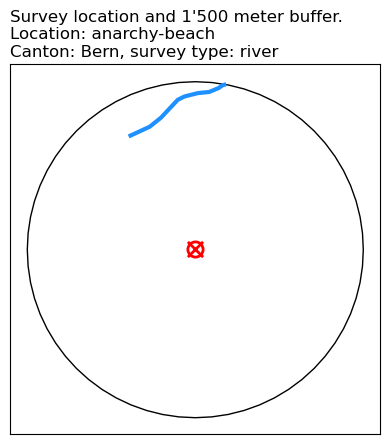

In [20]:
fig, ax = plt.subplots()

abuffer.plot(ax=ax, facecolor='white', edgecolor='black')
this_point.plot(ax=ax, zorder=5, marker='o', markersize=120, color='white', edgecolor='red', linewidth=2)
this_point.plot(ax=ax, zorder=5, marker='x', markersize=120, color='red', linewidth=2)
ariv.plot(ax=ax, linewidth=3, color='dodgerblue', zorder=4)

title = "Survey location and 1'500 meter buffer.\n"
title2 = f'Location: {a_location}\nCanton: Bern, survey type: river'
ax.set_title(f'{title}{title2}', loc='left')
ax.set_xticks([])
ax.set_yticks([])
glue('buffer-and-point', fig, display=True)
plt.close()

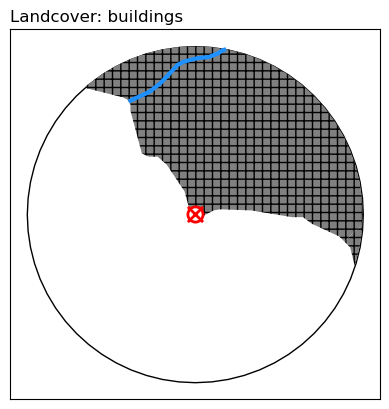

In [21]:
fig, ax = plt.subplots()
abuffer.plot(ax=ax, facecolor='white', edgecolor='black')
this_point.plot(ax=ax, zorder=5, marker='o', markersize=120, color='white', edgecolor='red', linewidth=2)
this_point.plot(ax=ax, zorder=5, marker='x', markersize=120, color='red', linewidth=2)
ariv.plot(ax=ax, linewidth=3, color='dodgerblue', zorder=4)
Siedl = buffer_content_i[buffer_content_i['land-cover'] == 'Siedl'].copy()
Siedl.plot(ax=ax, facecolor='gray',alpha=1, hatch='++', zorder=1)

title2 = f'Landcover: buildings'
ax.set_title(f'{title2}', loc='left')
ax.set_xticks([])
ax.set_yticks([])
glue('buffer-and-buildings', fig, display=True)
plt.close()

/tmp/ipykernel_250334/2395655611.py:8: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  wald.plot(ax=ax, facecolor='yellowgreen', edgecolor='darkgreen', alpha=1, hatch='oo',zorder=1)


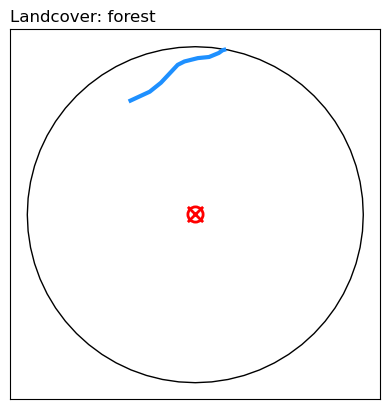

In [22]:
fig, ax = plt.subplots()
abuffer.plot(ax=ax, facecolor='white', edgecolor='black')
this_point.plot(ax=ax, zorder=5, marker='o', markersize=120, color='white', edgecolor='red', linewidth=2)
this_point.plot(ax=ax, zorder=5, marker='x', markersize=120, color='red', linewidth=2)
ariv.plot(ax=ax, linewidth=3, color='dodgerblue', zorder=4)

wald = buffer_content_i[buffer_content_i['land-cover'] == 'Wald'].copy()
wald.plot(ax=ax, facecolor='yellowgreen', edgecolor='darkgreen', alpha=1, hatch='oo',zorder=1)

title2 = f'Landcover: forest'
ax.set_title(f'{title2}', loc='left')
ax.set_xticks([])
ax.set_yticks([])
glue('buffer-and-forest', fig, display=True)
plt.close()

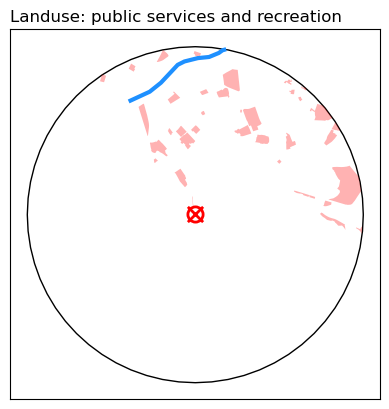

In [23]:
fig, ax = plt.subplots()

abuffer.plot(ax=ax, facecolor='white', edgecolor='black')
this_point.plot(ax=ax, zorder=5, marker='o', markersize=120, color='white', edgecolor='red', linewidth=2)
this_point.plot(ax=ax, zorder=5, marker='x', markersize=120, color='red', linewidth=2)
ariv.plot(ax=ax, linewidth=3, color='dodgerblue', zorder=4)


ps_comb.plot(ax=ax, zorder=3, facecolor='red', alpha=.3)
title2 = f'Landuse: public services and recreation'
ax.set_title(f'{title2}', loc='left')
ax.set_xticks([])
ax.set_yticks([])
glue('buffer-and-publicservice', fig, display=True)
plt.close()

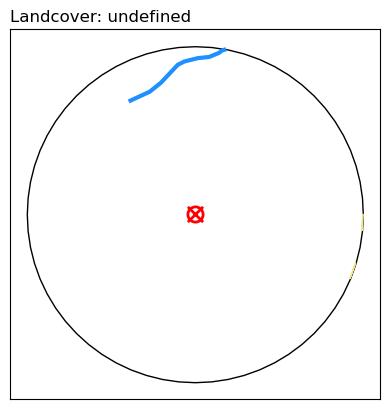

In [24]:
fig, ax = plt.subplots()

abuffer.plot(ax=ax, facecolor='white', edgecolor='black')
this_point.plot(ax=ax, zorder=5, marker='o', markersize=120, color='white', edgecolor='red', linewidth=2)
this_point.plot(ax=ax, zorder=5, marker='x', markersize=120, color='red', linewidth=2)
ariv.plot(ax=ax, linewidth=3, color='dodgerblue', zorder=4)


undef = buffer_content_i[buffer_content_i['land-cover'] == 'undefined'].copy()
undef.plot(ax=ax, facecolor='khaki', edgecolor='khaki', alpha=1, zorder=1)

title2 = f'Landcover: undefined'
ax.set_title(f'{title2}', loc='left')
ax.set_xticks([])
ax.set_yticks([])
glue('buffer-and-undefined', fig, display=True)
plt.close()

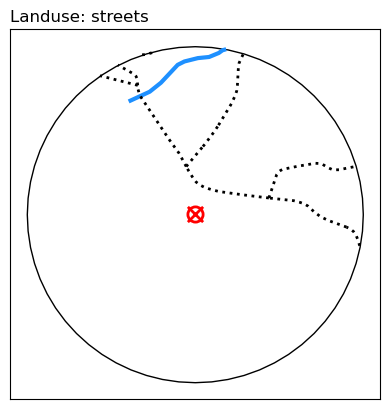

In [25]:
fig, ax = plt.subplots()

abuffer.plot(ax=ax, facecolor='white', edgecolor='black')
this_point.plot(ax=ax, zorder=5, marker='o', markersize=120, color='white', edgecolor='red', linewidth=2)
this_point.plot(ax=ax, zorder=5, marker='x', markersize=120, color='red', linewidth=2)
ariv.plot(ax=ax, linewidth=3, color='dodgerblue', zorder=2)


streets.plot(ax=ax, edgecolor='black', linestyle=':', linewidth=2, alpha=1, zorder=2)

title = "Survey location and 1'500 meter buffer.\n"
title2 = f'Landuse: streets'
ax.set_title(f'{title2}', loc='left')
ax.set_xticks([])
ax.set_yticks([])
glue('buffer-and-streets', fig, display=True)
plt.close()

/tmp/ipykernel_250334/2500445883.py:12: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  wald.plot(ax=ax, facecolor='yellowgreen', edgecolor='darkgreen', alpha=1, hatch='oo',zorder=1)


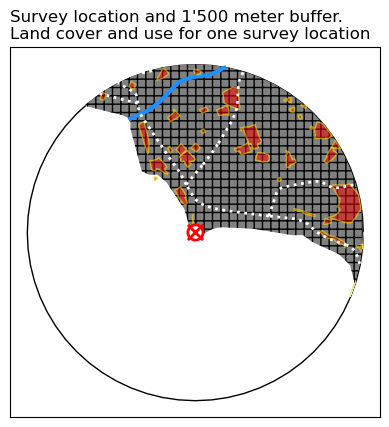

In [26]:
fig, ax = plt.subplots()

abuffer.plot(ax=ax, facecolor='white', edgecolor='black')
this_point.plot(ax=ax, zorder=5, marker='o', markersize=120, color='white', edgecolor='red', linewidth=2)
this_point.plot(ax=ax, zorder=5, marker='x', markersize=120, color='red', linewidth=2)
ariv.plot(ax=ax, linewidth=3, color='dodgerblue', zorder=3)

undef = buffer_content_i[buffer_content_i['land-cover'] == 'undefined'].copy()
undef.plot(ax=ax, facecolor='khaki', edgecolor='khaki', alpha=1, zorder=1)

wald = buffer_content_i[buffer_content_i['land-cover'] == 'Wald'].copy()
wald.plot(ax=ax, facecolor='yellowgreen', edgecolor='darkgreen', alpha=1, hatch='oo',zorder=1)

Siedl = buffer_content_i[buffer_content_i['land-cover'] == 'Siedl'].copy()
Siedl.plot(ax=ax, facecolor='gray',alpha=1, hatch='++', zorder=1)




streets.plot(ax=ax, edgecolor='white', linestyle=':', linewidth=2, alpha=1, zorder=4)

ps_comb.plot(ax=ax, zorder=3, facecolor='red', edgecolor='yellow', alpha=.5)

title = "Survey location and 1'500 meter buffer.\n"
title2 = 'Land cover and use for one survey location'
ax.set_title(f'{title}{title2}', loc='left')
ax.set_xticks([])
ax.set_yticks([])
glue('buffer-all', fig, display=True)
plt.close()

(calculating-land-use)=
# Extracting land use values

This is a summary of the methods used to extract topographical features from vector and points layers. The source for the vector layer is  [swissTLMRegio](https://www.swisstopo.admin.ch/de/landschaftsmodell-swisstlmregio). 

QGIS is not the optimal tool for this operation if the intention is to automate the aquisition of the data. However for a limited number of users and relatively few sample locations added each year QGIS is adequate to the task. A summary of the methods for using QGIS is [below](usingqgis).

__Note: 1'500 meter buffer (circular)__

The land-use chapter in the federal report generated alot of interest [Land use profile - german](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/land_use_correlation.html). It inspired an academic article and collaboration with Wagenigen Research and University.

__Why don't the percentages add up to 100 ?__

This is because some features listed on the map are superimposed on to others. For example a wooded area may contain a public park, this would mean that the park is considered a feature and has a definite surface area but this is in addition to the surface area of the forested area where the park is located. In general we can define the difference in this way: 

__Land-cover:__ Are elements such as buildings, forest, orchard or undefined. There is at least one land-cover element for each survey location. If so then it takes 100% of the available dry land. 

__Land-use:__ Are elements that may or may not be in the buffer. These are items like schools, hospitals, water-treatment plants. Individually they are only a small portion of the available dry land.

## Technical requirements

In addition to pandas, python and numpy, the following python packages are required:

1. Geopandas
2. Shapely

### A point and a buffer

The first step is to create a buffer of the appropriate radius with the point (survey locatio) at the center. The point is constructed by using gps coordinates for the location as arguments to `shapely.geometry.Point`. This is then converted to Geopandas.GeodataFrame (gdf) using the coordinate reference system (crs) of the point data. From the gdf, use the buffer method and collect the bounds.

__Making a buffer from a point__
```python

# method to make the buffer, the point and the bufferbounds
def a_point_buffer(this_location: pd.Series, buffer_radius: int = 1500, coordinate_crs: str = 'epsg:4326', to_crs: str = "epsg:2056"):
    # create a point, a buffer and buffer bounds for one location
    this_geometry = [Point(this_location.longitude, this_location.latitude)]
    this_shape = gpd.GeoDataFrame(this_location, geometry=this_geometry, crs=coordinate_crs)
    this_shape = this_shape.to_crs(to_crs)

    this_buffer = gpd.GeoDataFrame(geometry=this_shape.buffer(buffer_radius), crs=to_crs)
    location_buffer = this_buffer.dissolve()
    
    return this_shape, location_buffer, location_buffer.total_bounds

# select a location
a_location = river_locations[5]
# retrieve the grid coordinates
this_location = locations_and_coordinates.loc[[a_location]].copy()
# make the point, the buffer and the bounds
this_point, abuffer, bufferbounds = a_point_buffer(this_location)
```

### Retrieve location attributes: land-cover

The bounds and the buffer from the previous operation are used to construct an overlay for the .SHP file that holds the souce data. The name of the location is used to identify the buffer.

```python
def location_geo_attributes(bounds, buffer, shape_file, objcolumn: str = 'OBJVAL', objval: str ='land-cover', buffer_name: str = None):
    minx, miny, maxx, maxy = bounds
    landcover = gpd.read_file(shape_file, bbox=(minx, miny, maxx, maxy))
    landcover = landcover.drop_duplicates()
    landcover = gpd.overlay(landcover, buffer, how='intersection', keep_geom_type=True)
    landcover.rename(columns={objcolumn:objval}, inplace=True)
    landcover['buffer-name'] = buffer_name
    
    return landcover[['buffer-name', objval, 'geometry']]

# indentify the contents of the buffer    
buffer_content = location_geo_attributes(bufferbounds, abuffer, 'data/ignorethis/shapes/landcover.shp', buffer_name=a_location)
```
### Undefined areas

Not all areas of the buffer will have a defined land-cover. To identify those areas, all of the `buffer_content` is _joined_. For this we use the `shapely.unary_union` method and provide the `buffer_content` as an argument. This will produce a separate gdf that is the negative of the `buffer_content`. 

```python
# identify the undefined areas
combined_polygon = unary_union(buffer_content_i.geometry)
combined_Pn = gpd.GeoDataFrame({'geometry': [combined_polygon]}, crs=buffer_content_i.crs)
undefined = compute_undefined_sections_of_buffer(abuffer,combined_Pn, buffer_name=a_location)

# combine the known land cover with the undefined
buffer_content_i = pd.concat([buffer_content_i, undefined])

# assign 
buffer_content = assign_colors_to_polygons(buffer_content_i, colors=land_use_colors, objval='land-cover')
buffer_content = compute_landuse_percent_of_buffer(buffer_content, abuffer.geometry.area[0])
buffer_content['area_m2'] = buffer_content['area_m2'].astype(int)
```
To complete the process (for land-cover) the undefined areas are merged with the buffer_content and the surface area for each polygon is calculated.

### Public services: land-use

As noted earlier, some topographical features are overlayed on to other features. Here we are talking about two specific vector layers in the swissTLMRegio collection:

1. Nutuzungsareal : infrastructure or other usage
2. Freizeitareal : recreation area

We are interested in these layers because they give us information about the activities that may occur in proximity to the survey location. The same method is used to extract the polygons as was done with land use. However, we are using the `shapely.unary_union` method on the entire layer. Which means that we are not differentiating between the subcategories in each layer.

Once the buffer overlay has been applied to both layers the contents are combined and added to the buffer_content data:

```python
# infrastructure
args = dict(objcolumn='OBJEKTART', objval='land-use', buffer_name=a_location)
nz = location_geo_attributes(bufferbounds, abuffer, 'data/ignorethis/shapes/nutuzungsareal.shp', **args)
nz_comb = unary_union(nz.geometry)
nz_comb = gpd.GeoDataFrame({'geometry': [nz_comb]}, crs=buffer_content_i.crs)

# recreational areas
args = dict(objcolumn='OBJEKTART', objval='land-use', buffer_name=a_location)
fz = location_geo_attributes(bufferbounds, abuffer,'data/ignorethis/shapes/freizeit.shp', **args)
fz_comb = unary_union(fz.geometry)
fz_comb = gpd.GeoDataFrame({'geometry': [fz_comb]}, crs=buffer_content_i.crs)

# combine them all into one category called public services
public_service = pd.concat([nz, fz])
ps_comb = unary_union(public_service.geometry)

args = {
    'geometry': [ps_comb],
    'land-cover':['public-services'],
    'buffer-name':[a_location],
    'color':'red'
}
ps_comb = gpd.GeoDataFrame(args, crs=buffer_content_i.crs)
ps_comb = compute_landuse_percent_of_buffer(ps_comb, abuffer.geometry.area[0])

# combine the public services and the land-cover
land_use_profile = pd.concat([buffer_content, ps_comb])
land_use_profile['area_m2'] = land_use_profile['area_m2'].astype(int)
land_use_profile['rate'] = land_use_profile['rate'].round(2)
land_use_profile.rename(columns={'rate': '% of buffer'}, inplace=True)
```

Which results in the land-use profile for the location in question, (not including streets).

:::{card}
Land use and cover for a location.
^^^
```{glue} sample-landuse
```
:::

### Building a map of land cover



::::{grid} 1 1 2 2
:gutter: 1

:::{grid-item-card}

```{glue} buffer-and-point
```
+++
:::

:::{grid-item-card}

```{glue} buffer-and-buildings
```
+++
Surface area: 4'145'791 m², % of buffer: 59%

:::

:::{grid-item-card}

```{glue} buffer-and-forest
```
+++
Surface area: 1'528'977 m², % of buffer: 22%
:::

:::{grid-item-card}

```{glue} buffer-and-publicservice
```
+++
Surface area: 1'484'991 m², % of buffer: 21%
:::

:::{grid-item-card}

```{glue} buffer-and-undefined
```
+++
Surface area: 1'382'463 m², % of buffer: 20%
:::

:::{grid-item-card}

```{glue} buffer-and-streets
```
+++

Total length of streets : 17km

:::

:::{grid-item-card}

```{glue} buffer-all
```
+++

:::

::::




(usingqgis)=
## Using QGIS

For this method we are using the land-cover layer from swissTLM regio

finished columns = slug, attribute , attribute_type, area, dry,	scale

In QGIS:

1. create a buffer around each survey point
   * make sure that the survey location and feature_type is in the attributes of the new buffer layer
   * the survey locations are loaded as points from .csv file
   * reproject the points layer to the project CRS 

2. use the new buffer layer as an overlay to the land-cover layer
   * use the overlay intersection tool
   * select the fields to keep from the buffer (slug and feature type)
   * select the fields to keep from the land-cover layer
   * run the function
   * this creates a temporary layer called _intersection_

3. get the surface area of all the land-cover and land-use features in each buffer of the temporary layer
   * use the field calculator for the attribute table of the layer
   * in the field calculator, make a new field and enter the formula `\$area`
   * for this example the method is elipsoid _bessel 1841 (epsg 7001)_
   * this is set in the properties of the QGIS project
   * Export the layer as .csv

4. verify the land-use features per location
   * drop duplicate values: use location, feature and area to define duplicates
   * attention! different names for lake and reservoir
     * change Stausee to See

5. make a dry land feature
   * this is the surface area of the buffer that is not covered by water
   * substract the area of See from the area of the buffer
   * identify survey locations that have siginifcant water features but are not listed as lakes
  
6. Scale the land-use attributes of interest to the available dry-land
  
__Example making dry land columns and scaling the land-use__

    
```python
# separate locations that are lakes
# recall that feature type has a designator for lakes
lakes = lg[(lg.feature_ty == 'l') | lg.slug.isin(snl)].copy()

# from this subset of data separate the surface area covered by water
# set the slug to the index and substract the surface area of the water
# from the surface area of the buffer
lake_only = lakes[lakes.feature == "See"]
lo = lake_only[["slug", "area"]].set_index("slug")

# substract the lake value from the area of the buffer
lo["dry"] = 7065000 - lo.area
lodry = lo["dry"]

# merge the original land-use data from lakes with the
# the dry land results
lgi = lakes.merge(lo["dry"], left_on="slug", right_index=True)
# remove the lake feature from the features columns
lgi = lgi[lgi.feature != "See"].copy()

# scale the landuse feature to the available dry land
lgi["scale"] = (lgi.area/lgi.dry).round(3)

# repeat the process for locations that do not have a lake feature
# these locations are accounted for above
eliminate = [*snl, *lo.index]
# recuperate all other locations
rivers_parcs = lg[~lg.slug.isin(eliminate)].copy()
# define the dry land as the area of the buffer
rivers_parcs["dry"] = 7065000
# scale the features with the dry land value
rivers_parcs["scale"] = rivers_parcs.area/rivers_parcs.dry

# combine the two results
land_cover = pd.concat([rivers_parcs, lgi])
```
Once the dry land value is calculated for each buffer of the land-cover buffer use the dry-land value to scale the components of the land-use buffer

### Extracting street lengths

The tlmREgio streets or strasse layer is applicable.

__Note:__ the street lenghts are not scaled

finished columns = slug, attribute, attribute_type, length

__Attention:__

1. The streets layer can have many copies of the same street in a buffer
2. The cumulative sum of a street in a layer can exceed the radius of the buffer (windy roads)
3. Dissolving the polylines of each buffer in the layer is essential
4. Drop duplicate values on slug, attribute, length

1. Using the same 1'500 m buffer that was used for land-cover and land-use. Intersect the buffer with the street layer
2. Dissolve the polylines in each buffer
   * select the fields from the streets layer to keep (OBJVAL)
   * select the fields from the buffer layer to kepp (slug, feature_ty)
   * check the box `keep disjoint features separate`
   * run the function
   * export to .csv

In [27]:
land_cover_data = "data/end_process/land_cover.csv"
land_use_data = "data/end_process/land_use.csv"
street_data = "data/end_process/streets.csv"
intersection_attributes = "data/end_process/river_intersect_lakes.csv"
land_cover = pd.read_csv(land_cover_data)
land_use = pd.read_csv(land_use_data)
streets = pd.read_csv(street_data)
river_intersect_lakes = pd.read_csv(intersection_attributes)

#### Land-cover



Land-cover attributes

In [28]:
land_cover.attribute.unique()

array(['undefined', 'Siedl', 'Wald', 'Reben', 'Obstanlage'], dtype=object)

land-cover attribute translations

```python
land_cover_fr = {
    'undefined': 'Non défini',
    'Siedl': 'Siedl',
    'Wald': 'Forêt',
    'Reben': 'Vignes',
    'Obstanlage': 'Verger'
}

land_cover_en = {
    'undefined': 'Undefined',
    'Siedl': 'Settlement',
    'Wald': 'Forest',
    'Reben': 'Vines',
    'Obstanlage': 'Orchard'
}
```

Land-cover results for one location

In [29]:
land_cover_fr = {
    'undefined': 'Non défini',
    'Siedl': 'Siedl',
    'Wald': 'Forêt',
    'Reben': 'Vignes',
    'Obstanlage': 'Verger'
}

land_cover_en = {
    'undefined': 'Undefined',
    'Siedl': 'Settlement',
    'Wald': 'Forest',
    'Reben': 'Vines',
    'Obstanlage': 'Orchard'
}

In [30]:
land_cover[land_cover.slug == "parc-des-pierrettes"]

,slug,attribute,attribute_type,area,dry,scale
141,parc-des-pierrettes,undefined,land-cover,68285,3832559,0.018
623,parc-des-pierrettes,Siedl,land-cover,3606885,3832559,0.941
624,parc-des-pierrettes,Wald,land-cover,157389,3832559,0.041


#### Land-use

Land-use attributes:

In [31]:
land_use.attribute.unique()

array(['Baumschule', 'Friedhof', 'Schul- und Hochschulareal',
       'Wald nicht bestockt', 'Abwasserreinigungsareal',
       'Historisches Areal', 'Kraftwerkareal', 'Schrebergartenareal',
       'Truppenuebungsplatz', 'Unterwerkareal',
       'Kehrichtverbrennungsareal', 'Spitalareal',
       'Oeffentliches Parkareal', 'Messeareal',
       'Massnahmenvollzugsanstaltsareal', 'Kiesabbauareal',
       'Steinbruchareal', 'Klosterareal', 'Deponieareal', 'Antennenareal',
       'Lehmabbauareal'], dtype=object)

Land-use translations and groups

```python

land_use_fr = {
    'Baumschule': 'Pépinière',
    'Friedhof': 'Cimetière',
    'Schul- und Hochschulareal': 'Zone scolaire et universitaire',
    'Wald nicht bestockt': 'Forêt non peuplée',
    'Abwasserreinigungsareal': 'Zone de traitement des eaux usées',
    'Historisches Areal': 'Zone historique',
    'Kraftwerkareal': 'Zone de centrale électrique',
    'Schrebergartenareal': 'Zone de jardins familiaux',
    'Truppenübungsplatz': 'Terrain d\'entraînement militaire',
    'Unterwerkareal': 'Zone de sous-station',
    'Kehrichtverbrennungsareal': 'Zone d\'incinération des déchets',
    'Spitalareal': 'Zone d\'hôpital',
    'Öffentliches Parkareal': 'Zone de parc public',
    'Messeareal': 'Zone d\'exposition',
    'Massnahmenvollzugsanstaltsareal': 'Zone d\'établissement de traitement',
    'Kiesabbauareal': 'Zone d\'extraction de gravier',
    'Steinbruchareal': 'Zone de carrière',
    'Klosterareal': 'Zone de monastère',
    'Deponieareal': 'Zone de décharge',
    'Antennenareal': 'Zone d\'antennes',
    'Lehmabbauareal': 'Zone d\'extraction d\'argile'
}

land_use_en = {
    'Baumschule': 'Nursery',
    'Friedhof': 'Cemetery',
    'Schul- und Hochschulareal': 'School and University Area',
    'Wald nicht bestockt': 'Non-stocked Forest',
    'Abwasserreinigungsareal': 'Wastewater Treatment Area',
    'Historisches Areal': 'Historical Area',
    'Kraftwerkareal': 'Power Plant Area',
    'Schrebergartenareal': 'Allotment Garden Area',
    'Truppenübungsplatz': 'Military Training Ground',
    'Unterwerkareal': 'Substation Area',
    'Kehrichtverbrennungsareal': 'Waste Incineration Area',
    'Spitalareal': 'Hospital Area',
    'Öffentliches Parkareal': 'Public Park Area',
    'Messeareal': 'Exhibition Area',
    'Massnahmenvollzugsanstaltsareal': 'Correctional Facility Area',
    'Kiesabbauareal': 'Gravel Extraction Area',
    'Steinbruchareal': 'Quarry Area',
    'Klosterareal': 'Monastery Area',
    'Deponieareal': 'Landfill Area',
    'Antennenareal': 'Antenna Area',
    'Lehmabbauareal': 'Clay Extraction Area'
}

# land_uses_grouped:
# outdoor non technical use:
lu_non_tech = ['Friedhof', 'Hitorisches Areal', 'Schrebergartenareal', 'Öffentliches Parkareal', 'Messeareal', 'Klosterareal',  'Wald nicht bestockt']

# technical-extraction-incineration
lu_extraction = ['Kiesabbauareal', 'Steinbruchareal',  'Lehmabbauareal',]

# waste-water-treatment-powere
lu_technical = ['Kehrichtverbrennungsareal', 'Deponieareal', 'Deponieareal', 'Abwasserreinigungsareal','Unterwerkareal', 'Antennenareal']

# services:
lu_serives = ['Massnahmenvollzugsanstaltsareal', 'Schul- und Hochschulareal', 'Spitalareal']
```

Land-use for one location:

In [32]:
land_use_fr = {
    'Baumschule': 'Pépinière',
    'Friedhof': 'Cimetière',
    'Schul- und Hochschulareal': 'Zone scolaire et universitaire',
    'Wald nicht bestockt': 'Forêt non peuplée',
    'Abwasserreinigungsareal': 'Zone de traitement des eaux usées',
    'Historisches Areal': 'Zone historique',
    'Kraftwerkareal': 'Zone de centrale électrique',
    'Schrebergartenareal': 'Zone de jardins familiaux',
    'Truppenübungsplatz': 'Terrain d\'entraînement militaire',
    'Unterwerkareal': 'Zone de sous-station',
    'Kehrichtverbrennungsareal': 'Zone d\'incinération des déchets',
    'Spitalareal': 'Zone d\'hôpital',
    'Öffentliches Parkareal': 'Zone de parc public',
    'Messeareal': 'Zone d\'exposition',
    'Massnahmenvollzugsanstaltsareal': 'Zone d\'établissement de traitement',
    'Kiesabbauareal': 'Zone d\'extraction de gravier',
    'Steinbruchareal': 'Zone de carrière',
    'Klosterareal': 'Zone de monastère',
    'Deponieareal': 'Zone de décharge',
    'Antennenareal': 'Zone d\'antennes',
    'Lehmabbauareal': 'Zone d\'extraction d\'argile'
}

land_use_en = {
    'Baumschule': 'Nursery',
    'Friedhof': 'Cemetery',
    'Schul- und Hochschulareal': 'School and University Area',
    'Wald nicht bestockt': 'Non-stocked Forest',
    'Abwasserreinigungsareal': 'Wastewater Treatment Area',
    'Historisches Areal': 'Historical Area',
    'Kraftwerkareal': 'Power Plant Area',
    'Schrebergartenareal': 'Allotment Garden Area',
    'Truppenübungsplatz': 'Military Training Ground',
    'Unterwerkareal': 'Substation Area',
    'Kehrichtverbrennungsareal': 'Waste Incineration Area',
    'Spitalareal': 'Hospital Area',
    'Öffentliches Parkareal': 'Public Park Area',
    'Messeareal': 'Exhibition Area',
    'Massnahmenvollzugsanstaltsareal': 'Correctional Facility Area',
    'Kiesabbauareal': 'Gravel Extraction Area',
    'Steinbruchareal': 'Quarry Area',
    'Klosterareal': 'Monastery Area',
    'Deponieareal': 'Landfill Area',
    'Antennenareal': 'Antenna Area',
    'Lehmabbauareal': 'Clay Extraction Area'
}

# land_uses_grouped:
# outdoor non technical use:
lu_non_tech = ['Friedhof', 'Hitorisches Areal', 'Schrebergartenareal', 'Öffentliches Parkareal', 'Messeareal', 'Klosterareal',  'Wald nicht bestockt']

# technical-extraction-incineration
lu_extraction = ['Kiesabbauareal', 'Steinbruchareal',  'Lehmabbauareal',]

# waste-water-treatment-powere
lu_technical = ['Kehrichtverbrennungsareal', 'Deponieareal', 'Deponieareal', 'Abwasserreinigungsareal','Unterwerkareal', 'Antennenareal']

# services:
lu_serives = ['Massnahmenvollzugsanstaltsareal', 'Schul- und Hochschulareal', 'Spitalareal']

In [33]:
land_use[land_use.slug == "parc-des-pierrettes"]

,slug,attribute,attribute_type,area,dry,scale
685,parc-des-pierrettes,Abwasserreinigungsareal,land-use,49488,3832559,0.012913
686,parc-des-pierrettes,Friedhof,land-use,11325,3832559,0.002955
687,parc-des-pierrettes,Oeffentliches Parkareal,land-use,175591,3832559,0.045816
688,parc-des-pierrettes,Schrebergartenareal,land-use,17306,3832559,0.004516
689,parc-des-pierrettes,Schul- und Hochschulareal,land-use,1189161,3832559,0.310279


#### Streets

Streets attributes:

In [34]:
streets.attribute.unique()

array(['Autostr', 'Fahrstraes', 'Fussweg', 'HauptStrAB6', 'VerbindStr4',
       'NebenStr3', 'VerbindStr6', 'Autobahn', 'HauptStrAB4', 'NebenStr6',
       'Autob_Ri'], dtype=object)

Streets: translations and groups

```python
streets_fr = {
    'Autostr': 'autoroute',
    'NebenStr3': 'route secondaire 3',
    'NebenStr6': 'route secondaire 6',
    'HauptStrAB6': 'route principale 6',
    'HauptStrAB4': 'route principale 4',
    'Fahrstraes': 'chemin carrossable',
    'Fussweg': 'chemin pédestre',
    'Autobahn': 'autoroute',
    'Autob_Ri': 'autoroute',
    'VerbindStr4': 'route de liason 4',
    'VerbindStr6': 'route de liason 6',   
}

streets_en = {
    'Autostr': 'freeway',
    'NebenStr3': 'surface streets 3',
    'NebenStr6': 'surface streets 3 6',
    'HauptStrAB6': 'inter regional 6',
    'HauptStrAB4': 'inter regional 4',
    'Fahrstraes': 'bridle path',
    'Fussweg': 'pedestrian trail',
    'Autobahn': 'freeway',
    'Autob_Ri': 'freeway',
    'VerbindStr4': 'intra regional 4',
    'VerbindStr6': 'intra regional 6',   
}

```

The streets at one survey location:

In [35]:
streets_fr = {
    'Autostr': 'autoroute',
    'NebenStr3': 'route secondaire 3',
    'NebenStr6': 'route secondaire 6',
    'HauptStrAB6': 'route principale 6',
    'HauptStrAB4': 'route principale 4',
    'Fahrstraes': 'chemin carrossable',
    'Fussweg': 'chemin pédestre',
    'Autobahn': 'autoroute',
    'Autob_Ri': 'autoroute',
    'VerbindStr4': 'route de liason 4',
    'VerbindStr6': 'route de liason 6',   
}

streets_en = {
    'Autostr': 'freeway',
    'NebenStr3': 'surface streets 3',
    'NebenStr6': 'surface streets 3 6',
    'HauptStrAB6': 'inter regional 6',
    'HauptStrAB4': 'inter regional 4',
    'Fahrstraes': 'bridle path',
    'Fussweg': 'pedestrian trail',
    'Autobahn': 'freeway',
    'Autob_Ri': 'freeway',
    'VerbindStr4': 'intra regional 4',
    'VerbindStr6': 'intra regional 6',   
}

str_surface = ['NebenStr3', 'NebenStr6']
str_ped_br = ['Fahrstraes', 'Fussweg']
str_main = [ 'HauptStrAB6', 'VerbindStr4','VerbindStr6', 'HauptStrAB4', 'NebenStr6']
str_auto = ['Autobahn', 'Autostr', 'Autob_Ri']

In [36]:
streets[streets.slug == "parc-des-pierrettes"]

,slug,attribute_type,attribute,length
638,parc-des-pierrettes,streets,Autobahn,1685
639,parc-des-pierrettes,streets,Fahrstraes,1046
640,parc-des-pierrettes,streets,Fussweg,3257
641,parc-des-pierrettes,streets,HauptStrAB6,2918
642,parc-des-pierrettes,streets,NebenStr3,2850
643,parc-des-pierrettes,streets,VerbindStr4,67
644,parc-des-pierrettes,streets,VerbindStr6,2864


## Rivers: intersection, size and class

This requires the 1'500 m buffer created at the begininng and the rivers layer and the lakes layer.

### intersection, size and class
1. Create a points layer of the intersection of rivers to lakes
   * Keep only points that are labeled as river (fluss, fluss_u)
   * Use the attribute table to select the points
2. Overlay the 1 500 m buffer on the new layer and collect all the intersections within each buffer
   * export to .csv
3. Check for intersections that do not have lake name
   * not all lakes and rivers have names in the layer
   * find the correct name for the lake and add it to the record
   * replace river names with nan value with "no name"

### distance to intersection

__Note:__ the intersection points layer needs to be available

1. Using the `hub lines` tool in QGIS draw lines from survey location to intersect location
   * Limit the distance to the radius of the buffer
   * join on the slug field in both layers
   * eliminate duplicates
   * calculate the length of the line with `$length` in field calculator of the attribute table
   * export to .csv
  
2. Identify locations (slugs) that are missing either the river_name or lake
   * use the previous results (intersection, size and class) to fill in the missing values
   * check that slugs not in the distance matrix are truly without intersections 


In [37]:
river_intersect_lakes[river_intersect_lakes.slug == "parc-des-pierrettes"]

,slug,lake,river_name,size,class,distance,attribute_type
72,parc-des-pierrettes,Le Léman,La Mèbre,8,8,333,river intersection


In [38]:
%watermark -a hammerdirt-analyst -co --iversions

Author: hammerdirt-analyst

conda environment: cantonal_report

matplotlib: 3.8.4
geopandas : 0.14.4
pandas    : 2.2.2

